<a href="https://colab.research.google.com/github/UrDailyCs/datasetsQuizML/blob/main/Kel5_Final_Project_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Toxic Comment Classification

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
!nvidia-smi

Sun Jun 19 14:00:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Import Library

In [3]:
!pip install nltk
!pip install tensorflow_text
!pip install torchmetrics
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 5.3 MB/s 
     |████████████████████████████████| 511.7 MB 6.1 kB/s 
     |████████████████████████████████| 1.6 MB 52.6 MB/s 
     |████████████████████████████████| 438 kB 76.0 MB/s 
     |████████████████████████████████| 5.8 MB 50.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstal

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords 
from nltk.stem.lancaster import LancasterStemmer
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score,multilabel_confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import string
import re
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
from torchmetrics.functional import accuracy,auroc
import shutil
import sys

##Import training datasets

Dataset yang kami gunakan berasal dari github, namun sebenarnya ini adalah dataset yang dipakai untuk kompetisi kaggle.

dataset ini sendiri berisikan komen dari wikipedia

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/line-by-line/toxic_comments_classifier/master/Datasets%20from%20Kaggle%20(toxic)/train.csv')

In [ ]:
df.head(15)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [ ]:
df.shape

(159571, 8)

In [6]:
TARGETS = df.columns.tolist()[2:]
TARGETS

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


#Explore the data

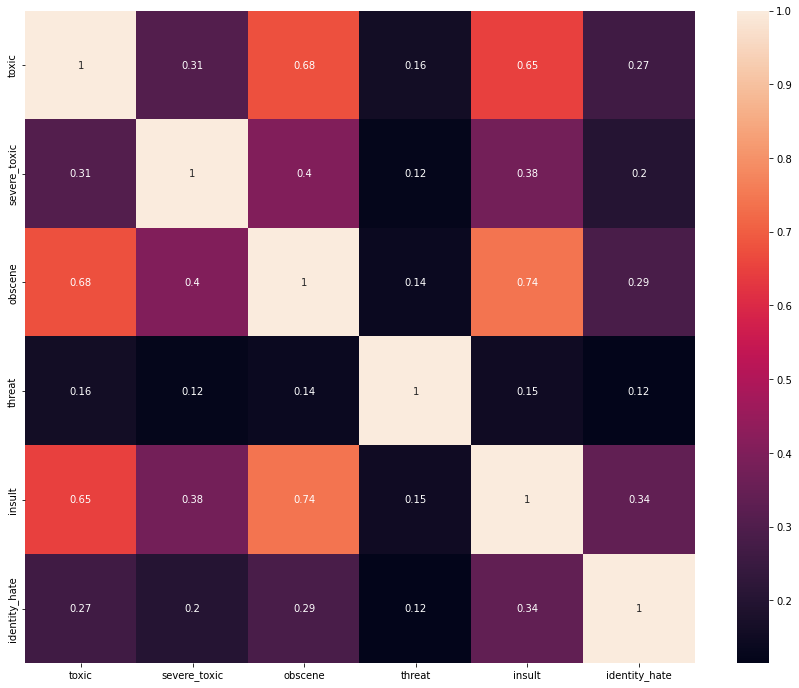

In [17]:
plt.figure( figsize=[15,12])
_=sns.heatmap(df.corr(), annot= True)

In [18]:
df.isnull().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [19]:
print("untuk toxic")
print(df['toxic'].value_counts(), '\n')

print("untuk severe_toxic")
print(df['severe_toxic'].value_counts(), '\n')

print("untuk obscene")
print(df['obscene'].value_counts(), '\n')

print("untuk threat")
print(df['threat'].value_counts())

print("untuk insult")
print(df['insult'].value_counts(),'\n')

print("untuk identity_hate")
df['identity_hate'].value_counts()

untuk toxic
0    144277
1     15294
Name: toxic, dtype: int64 

untuk severe_toxic
0    157976
1      1595
Name: severe_toxic, dtype: int64 

untuk obscene
0    151122
1      8449
Name: obscene, dtype: int64 

untuk threat
0    159093
1       478
Name: threat, dtype: int64
untuk insult
0    151694
1      7877
Name: insult, dtype: int64 

untuk identity_hate


0    158166
1      1405
Name: identity_hate, dtype: int64

#Handling Imabalance dataset


Buang column ID karena tidak penting untuk kasus ini

In [7]:
df=df.iloc[:,1:]

In [ ]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:

data_count=df.iloc[:,1:].sum()
data_count

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [11]:
data_count_list = list(data_count)
data_count_list

[15294, 1595, 8449, 478, 7877, 1405]

In [8]:
clean_df = df[df[TARGETS].sum(axis=1) == 0]
clean_df.shape

(143346, 7)

In [9]:
toxic_df = df[df[TARGETS].sum(axis=1) > 0]
toxic_df.shape

(16225, 7)

##Visualize jumlah komen dari tiap kelas dalam grafik

In [14]:
label=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','clean']
data_count_list.append(clean_df.shape[0])
x=label
y=data_count_list

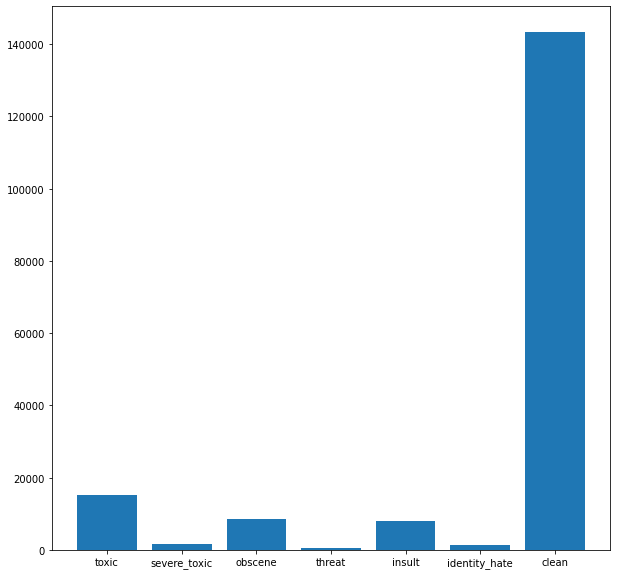

In [15]:

plt.figure(figsize=(10,10))
x1=np.arange(7)
plt.bar(x=np.arange(7),height=y)
plt.xticks(x1,labels=x)
plt.show()

##Karena komen yang tidak toxic terlalu banyak, sehingga saya akan sample saja

In [20]:
clean_df= clean_df.sample(16000,random_state=42).reset_index(drop=True)
clean_df.shape

(16000, 7)

In [21]:
concat_df= pd.concat([clean_df, toxic_df])
concat_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"""\n\nOh, don't worry about me, Sandstein. I'm ...",0,0,0,0,0,0
1,Are you trying to dispute that fact?,0,0,0,0,0,0
2,SWOT analysis \n\nThis source – Align Technolo...,0,0,0,0,0,0
3,"cover \n\nso, do we want a current or older co...",0,0,0,0,0,0
4,P.S. It's probably worth setting up a template...,0,0,0,0,0,0


Kita shuffle agar tidak monoton

In [22]:
concat_df= concat_df.sample(frac=1,random_state=42).reset_index(drop=True)

In [23]:
concat_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"""\n\nTell you the truth, I really don't mind t...",1,0,0,0,0,0
1,Quote by Chen in intro \n\nI did not see anyth...,0,0,0,0,0,0
2,"""\n\n Response \n\n1. Photo selection: On 3/15...",0,0,0,0,0,0
3,"I am open to your idea, which I think is desis...",0,0,0,0,0,0
4,Rather than simply deleting the picture of a g...,0,0,0,0,0,0


#Clean Texts

buang '\\n' dan juga remove double space

In [24]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
concat_df['comment_text'] = concat_df['comment_text'].map(alphanumeric)
concat_df['comment_text']= concat_df['comment_text'].map(lambda x: re.sub(r'\n',r' ', x))
concat_df['comment_text']= concat_df['comment_text'].map(lambda x: re.sub(r'  ',r' ', x))
concat_df['comment_text']=concat_df['comment_text'].str.strip()

In [25]:
concat_df['comment_text'][0]

'" Tell you the truth, I really don\'t mind this block at all. I did harass. That is what you do in a war where no one plays by the rules. Quite frankly I am fed up with being constantly blocked by silly Wiki morons and am glad I said it. We all know the politics around here so let\'s stop talking past each other, right? Look at why I was deleted leading to all this, not after World war III was in mid session. Who Started it? Not I! Until Wikipedia deals with morons I have no choice but to retain this position as this madness known as ""Wikipedia"" writes trash on my life. Liberals will do what liberals do: Level the playing field for the idiots, and I will be there to respond."'

##Remove stopwords

In [ ]:
nltk.download('stopwords')

In [ ]:
stop= stopwords.words('english')

In [ ]:
df['comment_text'][0]

##Cleaning the texts

In [ ]:
# remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Remove all double spaces
remove_double_space = lambda x: re.sub(r'  ',r' ', x)

# remove stopwords first
concat_df['comment_text']=concat_df['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Apply all the lambda functions wrote previously through .map on the comments column
concat_df['comment_text'] = concat_df['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii).map(remove_double_space)

concat_df['comment_text'][0]

#Split into train and test

In [26]:
df_train, df_test= train_test_split(concat_df,test_size=0.1, random_state=42)
df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [ ]:
df_train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Isabelle Fuhrman Thanks for removing something...,0,0,0,0,0,0
1,"BJP pro hindutva , aren't you living in this ...",1,0,0,0,0,0
2,"Sup dude. I'm not spamming. Fuck you, learn to...",1,0,1,0,1,0
3,"Dear Snigbrook Your days are numbered, the sta...",1,0,1,1,1,0
4,""" She did the usual disappear at Christmas act...",0,0,0,0,0,0


#Getting the BERT TensorFlow

In [27]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [28]:
def getEmbedding(sentences):
  preprocessed_text= bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

In [32]:
tst_preproc= bert_preprocess(['I Love Natural Language Processing'])
tst_preproc

{'input_mask': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 

In [33]:
tst_preproc['input_word_ids']

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[ 101, 1045, 2293, 3019, 2653, 6364,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]], dtype=int32)>

In [ ]:
bert_encoder(tst_preproc)

In [37]:
getEmbedding(["I love Natural Language Processing","Final Project"])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.79857767, -0.22563332,  0.30046916, ...,  0.07815453,
        -0.540463  ,  0.8255246 ],
       [-0.8693729 , -0.3164801 , -0.0955715 , ...,  0.09811448,
        -0.54874235,  0.8176817 ]], dtype=float32)>

In [ ]:
# getEmbedding(df.comment_text)

In [45]:
check_bert= getEmbedding([
                          "Audia studying for the exam",
                          "Joseph is reviewing for the tes",
                          "Nicholas is playing games",
                          "Book",
                          "Cars are getting cheaper, but expensive at the same time",
                          "pc components are so expensive this days",
                          "class",
                          "toyota",
                          'work',
                          "war",
                          "apple were eaten by monkeys",
                          "banana",
                          "Elon Musk",
                          "Jeff Bezos"
])

In [52]:
print(cosine_similarity([check_bert[0]], [check_bert[1]]))
print(cosine_similarity([check_bert[2]], [check_bert[4]]))
print(cosine_similarity([check_bert[3]], [check_bert[4]]))
print(cosine_similarity([check_bert[-1]], [check_bert[-2]]))
print(cosine_similarity([check_bert[-2]], [check_bert[-3]]))

[[0.9238905]]
[[0.46023497]]
[[0.6123694]]
[[0.9872035]]
[[0.89336324]]


#Bert PyTorch

In [53]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [54]:
# hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 4
LEARNING_RATE = 1e-05

In [55]:
class CustomDataset (torch.utils.data.Dataset):
  def __init__(self,df,tokenizer,max_len):
    self.df= df
    self.comment= df['comment_text']
    self.targets = df[TARGETS].values

    self.tokenizer=tokenizer
    self.max = max_len
  
  def __len__(self):
    return len(self.comment)

  def __getitem__(self,index):
    comment= str(self.comment[index])
    comment = " ".join(comment.split())

    inputs = self.tokenizer.encode_plus(
        comment,
        None,
        add_special_tokens= True,
        max_length= self.max,
        padding= 'max_length',
        truncation= True,
        return_token_type_ids= True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }


In [56]:
df_train= CustomDataset(df_train, tokenizer, MAX_LEN)
df_test= CustomDataset(df_test, tokenizer,MAX_LEN)

In [57]:
print(df_test.df['comment_text'][2])
print(df_test[2])

Pride: Silva vs. Grenier Welterweight Bout: Anderson Silva vs. Marcelo Grenier Heavyweight Bout: Mark Hunt vs. Roy Nelson Middleweight Bout: Shogun Rua vs. Ryan Bader Middleweight Bout: Cyrille Diabaté vs. Tyler Johnson Johnson defeated Diabaté via KO (Punch) at : of round . Lightweight Bout: Jose Aldo vs. Renan Barao Aldo defeated Barao via TKO (Leg Kick) at : of round .
{'input_ids': tensor([  101,  6620,  1024, 11183,  5443,  1012, 24665, 18595,  2121, 20882,
        10094,  1024,  5143, 11183,  5443,  1012, 24984, 24665, 18595,  2121,
         8366, 10094,  1024,  2928,  5690,  5443,  1012,  6060,  5912, 18741,
        10094,  1024, 26822, 12734, 21766,  2050,  5443,  1012,  4575,  2919,
         2121, 18741, 10094,  1024, 16049,  2571, 22939, 20179,  5443,  1012,
         7482,  3779,  3779,  3249, 22939, 20179,  3081, 12849,  1006,  8595,
         1007,  2012,  1024,  1997,  2461,  1012, 12038, 10094,  1024,  4560,
        28163,  5443,  1012, 14916,  2319,  3347,  7113, 28163,  

In [58]:
train_data_loader = torch.utils.data.DataLoader(df_train, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(df_test, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [59]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

##Create Checkpoint

In [79]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

##BERT CLASS

In [61]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 6)
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

##Training

In [62]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [66]:
val_targets=[]
val_outputs=[]
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
def train_model(n_epochs, training_loader, validation_loader, model,checkpoint_path,
                 best_model_path,optimizer):
   
  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf
  
  for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0
    val_targets=[]
    val_outputs=[]

    model.train()
    # print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #if batch_idx%5000==0:
         #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #print('after loss data in training', loss.item(), train_loss)
    
    # print('===============  Epoch {}: Training End   =============== '.format(epoch))
    
    # print('================ Epoch {}: Validation Start =============== '.format(epoch))
    ######################    
    # validate the model #
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            # print("pnjg target", len(val_targets))
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
            # print("pnjg outputs", len(val_outputs))

      # print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.5f} \tAverage Validation Loss: {:.5f} acurracy score = {:.5f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            roc_auc_score(val_targets, val_outputs)
            ))
      # print("roc score", roc_auc_score(val_targets, val_outputs))
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
        # save checkpoint
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.5f} --> {:.5f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))

  return model

In [64]:
checkpoint="/content/drive/MyDrive/FinalNLP/curr_ckpt.pt"
bestModel= "/content/drive/MyDrive/FinalNLP/best.pt"

In [67]:
trained_model = train_model(EPOCHS,train_data_loader,val_data_loader,model,checkpoint,bestModel,optimizer)

Epoch: 1 	Avgerage Training Loss: 0.00016 	Average Validation Loss: 0.00140 acurracy score = 0.96659
Validation loss decreased (inf --> 0.00140).  Saving model ...
############# Epoch 1  Done   #############

Epoch: 2 	Avgerage Training Loss: 0.00014 	Average Validation Loss: 0.00153 acurracy score = 0.96436
############# Epoch 2  Done   #############

Epoch: 3 	Avgerage Training Loss: 0.00012 	Average Validation Loss: 0.00151 acurracy score = 0.96537
############# Epoch 3  Done   #############

Epoch: 4 	Avgerage Training Loss: 0.00010 	Average Validation Loss: 0.00158 acurracy score = 0.96344
############# Epoch 4  Done   #############



In [80]:
final_model,opt, epch, loss= load_ckp(bestModel, trained_model,optimizer)

In [82]:
print(epch)
print(loss)

2
0.001401044849776343


In [86]:
len(val_targets) #nnti ambil 3323 elemen aja

3351

In [87]:
val_outputs_final=[]
val_targets_final=[]
final_model.eval()
valid_loss_final=0
with torch.no_grad():
      for batch_idx, data in enumerate(val_data_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss_final = valid_loss_final + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss_final))
            val_targets_final.extend(targets.cpu().detach().numpy().tolist())
            # print("pnjg target", len(val_targets))
            val_outputs_final.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

In [88]:
roc_auc_score(val_targets_final,val_outputs_final)

0.9665914873367477

In [ ]:
trained_model.eval()
valid_loss=0
with torch.no_grad():
      for batch_idx, data in enumerate(val_data_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            # print("pnjg target", len(val_targets))
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

0.9634418962759731

In [ ]:
trained_model = train_model(EPOCHS,train_data_loader,val_data_loader,model,checkpoint,bestModel,optimizer)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000024 	Average Validation Loss: 0.000180
Validation loss decreased (inf --> 0.000180).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.000018 	Average Validation Loss: 0.000181
############# Epoch 2  Done   #############



In [ ]:
trained_model = train_model(EPOCHS,train_data_loader,val_data_loader,model,checkpoint,bestModel,optimizer)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000015 	Average Validation Loss: 0.000187
Validation loss decreased (inf --> 0.000187).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.000012 	Average Validation Loss: 0.000218
############# Epoch 2  Done   #############



In [ ]:
valll[:][1]

[0.0074258483946323395,
 0.0018216728931292892,
 0.0048935022205114365,
 0.002250320976600051,
 0.003229815512895584,
 0.002004582667723298]

In [ ]:
len(valll[0])

6

In [ ]:
import numpy as np
ab= np.array(val)

In [ ]:
az= list(zip(*val))

In [ ]:
for i in az:
  print(i)

(0.22512079775333405, 0.0074258483946323395, 0.016126811504364014, 0.004862876143306494, 0.0037531331181526184, 0.0048414976336061954, 0.0039496347308158875, 0.8042276501655579)
(0.0016097503248602152, 0.0018216728931292892, 0.002177012152969837, 0.0023378345649689436, 0.0029421006329357624, 0.002185107208788395, 0.0028362965676933527, 0.021203121170401573)
(0.02532624825835228, 0.0048935022205114365, 0.009638953022658825, 0.005229161586612463, 0.004083527252078056, 0.004328157287091017, 0.005099293310195208, 0.8245008587837219)
(0.001790619338862598, 0.002250320976600051, 0.0022431209217756987, 0.0024816379882395267, 0.0037498893216252327, 0.0026724354829639196, 0.00306038954295218, 0.0024180354084819555)
(0.04227235168218613, 0.003229815512895584, 0.005189451854676008, 0.0033527505584061146, 0.0031946050003170967, 0.002907524351030588, 0.002960606710985303, 0.13679172098636627)
(0.007051749154925346, 0.002004582667723298, 0.0026523920241743326, 0.0026229238137602806, 0.00301970448344

In [ ]:
ab

array([[0.2251208 , 0.00160975, 0.02532625, 0.00179062, 0.04227235,
        0.00705175],
       [0.00742585, 0.00182167, 0.0048935 , 0.00225032, 0.00322982,
        0.00200458],
       [0.01612681, 0.00217701, 0.00963895, 0.00224312, 0.00518945,
        0.00265239],
       [0.00486288, 0.00233783, 0.00522916, 0.00248164, 0.00335275,
        0.00262292],
       [0.00375313, 0.0029421 , 0.00408353, 0.00374989, 0.00319461,
        0.0030197 ],
       [0.0048415 , 0.00218511, 0.00432816, 0.00267244, 0.00290752,
        0.00232782],
       [0.00394963, 0.0028363 , 0.00509929, 0.00306039, 0.00296061,
        0.00268412],
       [0.80422765, 0.02120312, 0.82450086, 0.00241804, 0.13679172,
        0.00462352]])

In [ ]:
ab[:,0].tolist()

[0.22512079775333405,
 0.0074258483946323395,
 0.016126811504364014,
 0.004862876143306494,
 0.0037531331181526184,
 0.0048414976336061954,
 0.0039496347308158875,
 0.8042276501655579]